Задание лабораторной работы основано на материалах домашнего задания по курсу от DeepSchool 3DCV

https://deepschool.ru/3dcv

### Установка пакетов

Начнем с установки необходимых пакетов python. Ничего необычного не понадобится - обычные numpy, cv2, matplotlib

In [1]:
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib

Теперь можно импортировать

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Гомография

Используя полученные на занятии новые знания, сделаем простейший выравниватель документов. Для начала нам нужна фотография документа, который мы будем выравнивать. Сделайте фотографию самостоятельно или найдите пример в интернете.

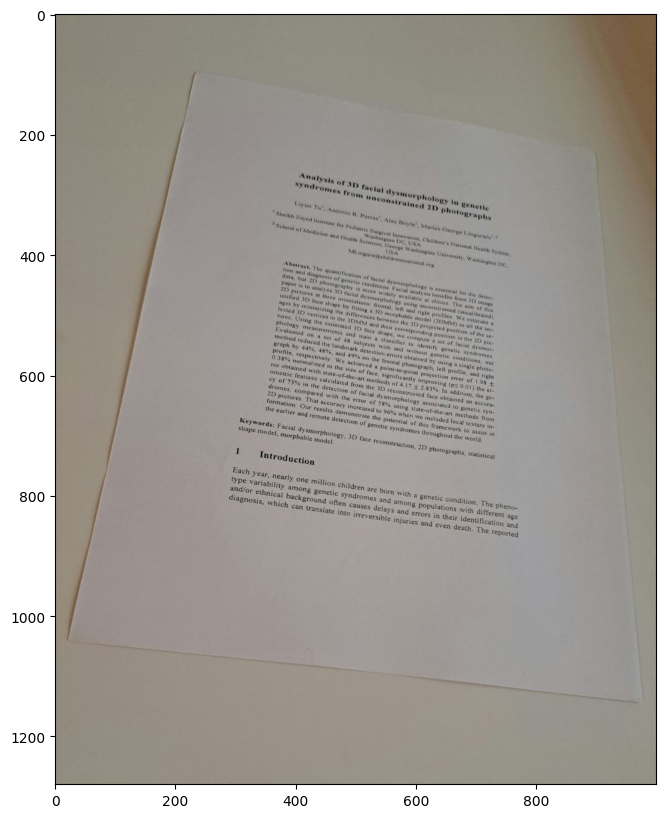

In [4]:
image = load_image("document.jpg")
plt.imshow(image)
plt.show()

Для начала нам нужно определить углы документа. Их можно найти автоматически, но предлагаем не отвлекаться на эту задачу. Поэтому сделаем это просто руками. Отсчет ведем от левого верхнего угла и по часовой стрелке

In [5]:
pts_src = np.array([[234, 96], [896, 228], [977, 1145], [20, 1040]])

In [6]:
image.shape

(1280, 1000, 3)

Далее нужно определить, в какие точки мы будем отображать эти углы - сделайте это самостоятельно. Предполагается, что в итоге мы хотим увидеть прямоугольник

In [7]:
pts_dst = np.array([[0, 0], [2100, 0], [2100, 2970], [0, 2970]]) # Определите желаемое положение для каждого угла

Теперь мы можем найти гомографию по четырем соответствиям между точками. Вам предлагается сделать это двумя способами - базово, с использованием OpenCV метода (пример можно найти [здесь](https://learnopencv.com/homography-examples-using-opencv-python-c/)) и продвинуто, с помощью самописной функции DLT. Можно легко найти уже написанные функции поиска гомографии с помощью DLT, поэтому снабжайте код пояснениями, чтобы было понятно, что вы разобрались, что происходит в коде.

In [8]:
def find_homography_opencv(src_pts: np.ndarray, dst_pts: np.ndarray) -> np.ndarray:
    src_pts = np.asarray(src_pts, dtype=np.float32)
    dst_pts = np.asarray(dst_pts, dtype=np.float32)

    H, status = cv2.findHomography(src_pts, dst_pts, method=0)  # 0 = обычный DLT

    return H

# Дополнительное задание

def find_homography_custom(src_pts: np.ndarray, dst_pts: np.ndarray) -> np.ndarray:
    """
    Custom homography using DLT method.
    src_pts, dst_pts: shape (N, 2), N >= 4
    Returns H: (3, 3)
    """

    N = src_pts.shape[0]
    A = []

    for i in range(N):
        x, y = src_pts[i]
        u, v = dst_pts[i]

        A.append([-x, -y, -1,  0,  0,  0, x*u, y*u, u])
        A.append([ 0,  0,  0, -x, -y, -1, x*v, y*v, v])

    A = np.array(A, dtype=np.float64)

    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1]

    H = h.reshape(3, 3)

    # Нормализация
    H = H / H[2, 2]

    return H

In [9]:
H = find_homography_opencv(pts_src, pts_dst)
H_custom = find_homography_custom(pts_src, pts_dst)

Зная гомографию, мы можем применить ее к изображению. Опять же, предлагается начать с готового метода из OpenCV (снова предлагается [этот](https://learnopencv.com/homography-examples-using-opencv-python-c/) пример). После этого можно попробовать написать кастомное преобразование изображения с помощью гомографии.

In [10]:
def warp_perspective_opencv(image: np.ndarray, H: np.ndarray, dsize: np.ndarray) -> np.ndarray:
    """
    image - исходное изображение
    H     - гомография (3×3)
    dsize - (width, height)
    """
    dsize = tuple(map(int, dsize))

    return cv2.warpPerspective(
        image, 
        H, 
        dsize,
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )


def warp_perspective_custom(image: np.ndarray, H: np.ndarray, dsize: np.ndarray) -> np.ndarray:

    out_w, out_h = map(int, dsize)
    h, w = image.shape[:2]

    # Инверсия гомографии
    H_inv = np.linalg.inv(H)

    # Сетка координат выхода
    ys, xs = np.meshgrid(np.arange(out_h), np.arange(out_w), indexing='ij')

    ones = np.ones_like(xs)
    dst_hom = np.stack([xs, ys, ones], axis=-1)   # (H,W,3)

    # Преобразование в src
    src = dst_hom @ H_inv.T                       # (H,W,3)
    src_x = src[..., 0] / src[..., 2]
    src_y = src[..., 1] / src[..., 2]

    # Маска валидных координат
    valid = (
        (src_x >= 0) & (src_x < w - 1) &
        (src_y >= 0) & (src_y < h - 1)
    )

    # Целые координаты
    x0 = np.floor(src_x).astype(np.int32)
    y0 = np.floor(src_y).astype(np.int32)
    x1 = x0 + 1
    y1 = y0 + 1

    # Коэффициенты интерполяции
    dx = src_x - x0
    dy = src_y - y0

    # Ограничение выхода за границы
    x0 = np.clip(x0, 0, w - 1)
    x1 = np.clip(x1, 0, w - 1)
    y0 = np.clip(y0, 0, h - 1)
    y1 = np.clip(y1, 0, h - 1)

    # Чтение пикселей
    Ia = image[y0, x0]
    Ib = image[y0, x1]
    Ic = image[y1, x0]
    Id = image[y1, x1]

    # Билинейная интерполяция
    wa = (1 - dx) * (1 - dy)
    wb = dx * (1 - dy)
    wc = (1 - dx) * dy
    wd = dx * dy

    out = wa[..., None]*Ia + wb[..., None]*Ib + wc[..., None]*Ic + wd[..., None]*Id \
          if image.ndim == 3 else wa*Ia + wb*Ib + wc*Ic + wd*Id

    # Заполняем нулями там, где выход за изображение
    output = np.zeros_like(out)
    output[valid] = out[valid]

    return output.astype(image.dtype)

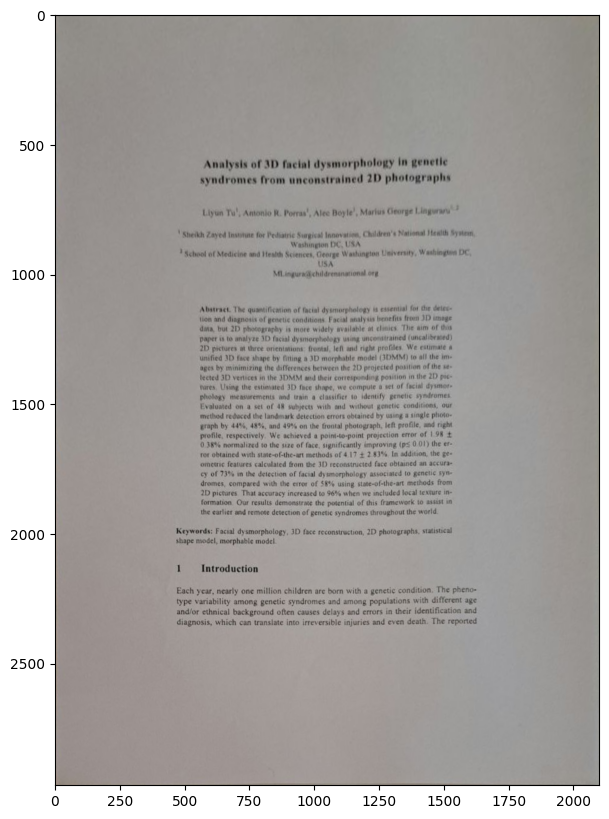

In [11]:
dsize = (2100, 2970)
im_out = warp_perspective_opencv(image, H, dsize)
plt.imshow(im_out)
plt.show()

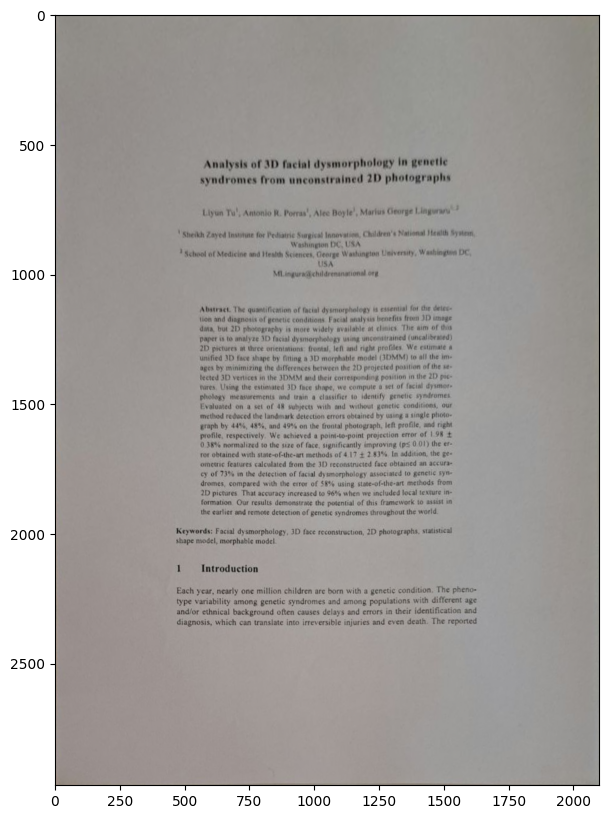

In [12]:
dsize = (2100, 2970)
im_out = warp_perspective_custom(image, H_custom, dsize)
plt.imshow(im_out)
plt.show()

### Калибровка

В данном разделе вам предлагается сделать калибровку камеры своего мобильного телефона. Как мы выяснили на занятии, для этого необходима калибровочная доска. Идеальным вариантом будет вывод шахматной доски на экран компьютера, так как он является настолько плоским, насколько это возможно в быту.
Генераторов досок в интернете предостаточно, откройте, например, [этот](https://markhedleyjones.com/projects/calibration-checkerboard-collection). Далее произведите серию снимков с телефона.

Общие рекомендации:
* Делайте побольше снимков. На практике часто снимают видео, но это на ваше усмотрение. Зависит от желания заморачиваться с распаковкой кадров и прореживанием их.
* Постарайтесь захватить максимум ракурсов: ближе/дальше, выбирайте разные углы наклона, вращайте камеру, постарайтесь захватить всё поле зрение камеры.
* На каждом снимке должна быть видна вся доска.

Далее проделайте калибровку с помощью стандартных методов OpenCV, пример можно найти [здесь](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html) или в миллионе других мест.

Попробуйте убрать дисторсию с помощью функции undistort. Стало ли лучше? Если стало только хуже, обратитесь к рекомендациям по съёмке для калибровки снова.

In [ ]:
Nx, Ny = 9, 7
square_size = 1.0

objpoints = []
imgpoints = []

import glob
import tqdm
images = glob.glob("chess/*.jpg")

for fname in tqdm(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (Nx-1, Ny-1), None)
    if ret:
        objp = np.zeros(((Ny-1)*(Nx-1), 3), np.float32)
        objp[:, :2] = np.mgrid[0:Nx-1, 0:Ny-1].T.reshape(-1, 2) * square_size
        objpoints.append(objp)
        imgpoints.append(corners)


ret, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

print("Матрица камеры:\n", K)
print("Коэффициенты дисторсии:\n", dist_coeffs)


100%|██████████| 19/19 [11:00<00:00, 34.74s/it]


Матрица камеры:
 [[2.89282077e+03 0.00000000e+00 1.51253856e+03]
 [0.00000000e+00 2.88984496e+03 1.96471742e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Коэффициенты дисторсии:
 [[ 2.79855888e-01 -2.60366334e+00 -6.00298341e-03  4.00795430e-04
   6.67009213e+00]]


In [16]:
img = cv2.imread(images[0])
h, w = img.shape[:2]
new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (w,h), 1, (w,h))
undistorted = cv2.undistort(img, K, dist_coeffs, None, new_camera_mtx)

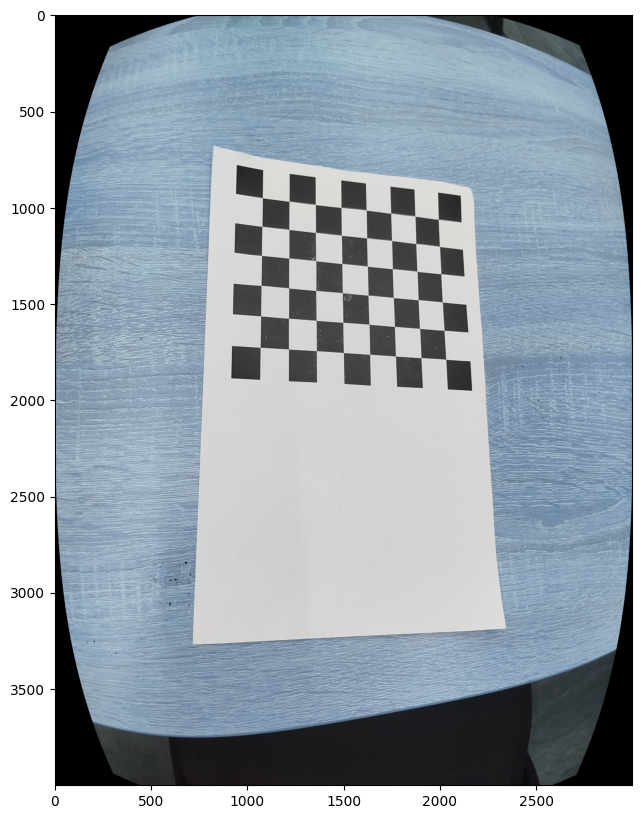

In [17]:
plt.imshow(undistorted)

### 2D/3D Преобразования

Представим, что у вас есть автомобиль, к крыше которого прикреплена RGBD камера. Такая камера снимает как обычная, но четвертым каналом она передает глубину объекта. Глубина объекта - это координаты Z объекта в системе координат камеры. Наша задача - научиться строить 3D карту по данным с сенсоров этого автомобиля.

Вам дано изображение с этой камеры в какой-то момент времени

In [18]:
def load_image(path: str) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

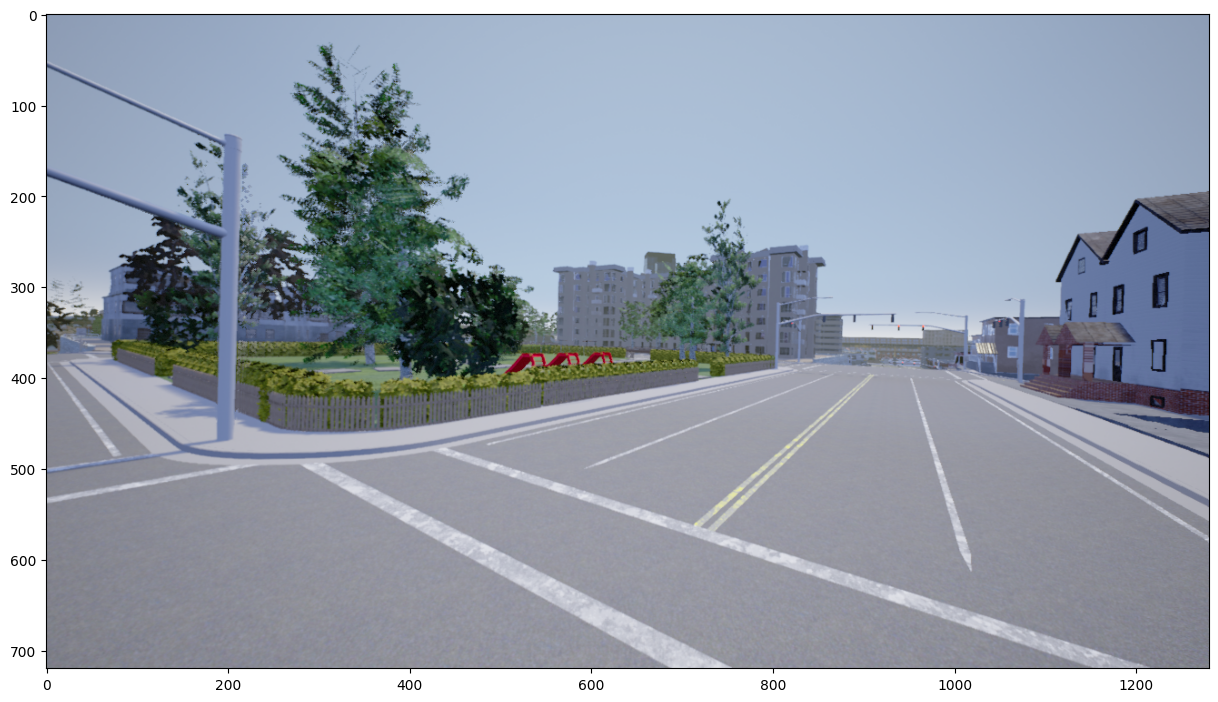

In [19]:
image1 = load_image("image1.png")
plt.imshow(image1)
plt.show()

А также соответствующая ей карта глубины

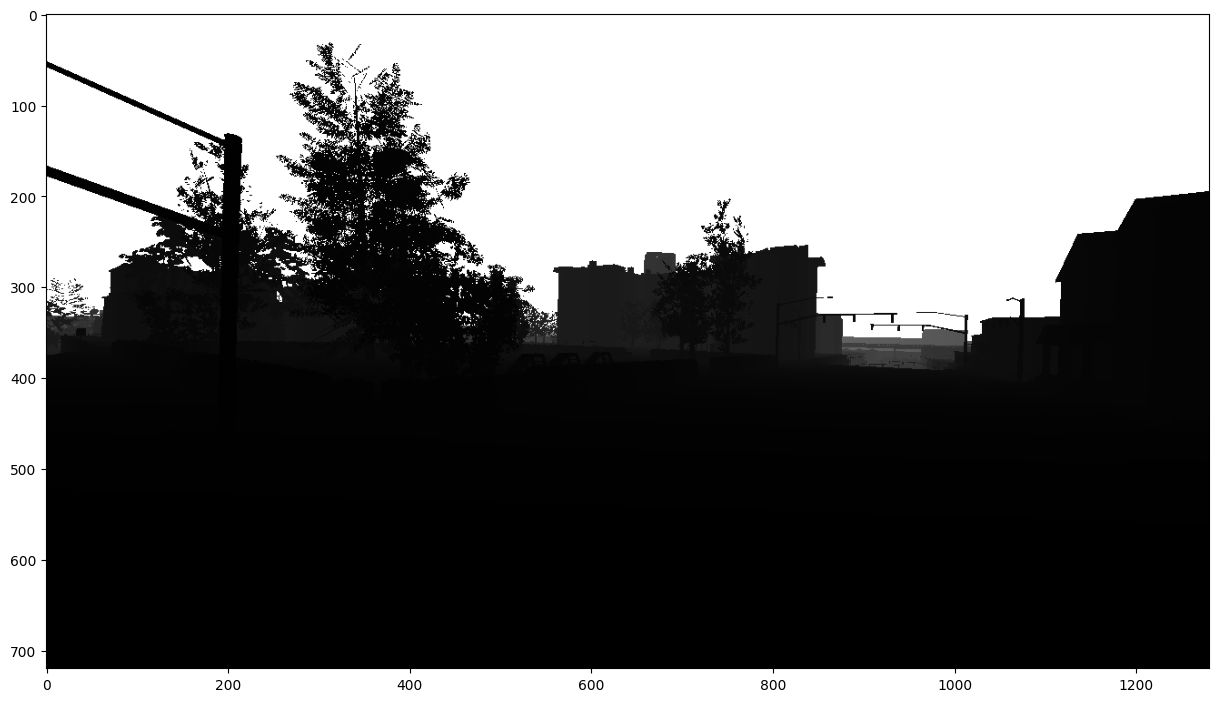

In [20]:
# Глубины даны нормализованными, от 0 до 1, что соответствует расстоянию от 0 до 1000м,
# поэтому здесь мы умножаем на 1000
depth1 = np.load("depth1.npy") * 1000
plt.imshow(depth1, cmap='gray')
plt.show()

Предположим, что мы заранее откалибровали наши камеры (либо калибровка указана в спецификации камеры). Вот эти данные

In [21]:
fx = 448.1551643293023
fy = 448.1551643293023
px = 640.0
py = 360.0

Составьте из этих данных матрицу камеры (формулу можно найти в слайдах)

In [22]:
K = np.array([
    [fx, 0,  px],
    [0,  fy, py],
    [0,   0,  1]
], dtype=np.float64)

Также далее нам пригодится обратная матрица для матрицы камеры (можно найти ее численно, но советуем воспользоваться аналитической формулой, она есть в слайдах про обратную проекцию)

In [23]:
K_inv = np.linalg.inv(K)

Итак, у нас все готово для построения 3D карты из данных первого изображения.
Для этого нам нужна формула обратной проекции (см. презентацию).
Давайте присмотримся повнимательнее к этой формуле.
u, v - это координаты пикселя. Мы хотим построить карту из всех пикселей, поэтому нам нужно пробежаться по всем их значениям. Чтобы векторизовать дальнейшие вычисления, будем записывать все по возможности в матрицах.
points_2d - матрица, в которой 2 строки (u и v), и w * h столбцов, где w и h - размеры изображения. То есть, эта матрица будет выглядеть примерно так

| 0 | 1 | 2 | ... | w-1 | 0 | 1 | ... | w-1 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0 | 0 | 0 | ... | 0 | 1 | 1 | ... | h-1 |

In [24]:
h, w = image1.shape[:2]
v_coords, u_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
points_2d = np.stack([u_coords.ravel(), v_coords.ravel()], axis=0)


Отлично, следующий шаг - перейти к однородным координатам. Здесь это просто - добавьте единицу в качестве третьей координаты для каждого пикселя

In [25]:
ones = np.ones((1, points_2d.shape[1]), dtype=points_2d.dtype)
points_2d_h = np.vstack([points_2d, ones])

Самое время перейти к обратной проекции. Еще раз взгляните на формулу со слайда с обратной проекцией - что нужно сделать, чтобы из пикселя в однородных координатах получить луч в однородных координатах?

In [26]:
rays = K_inv @ points_2d_h

Теперь перейдем к последнему этапу формулы со слайда с обратной проекцией - применение глубины. Используйте ранее загруженную карту глубины

In [27]:
cloud1 = rays * depth1.ravel() # TODO: преобразуйте лучи и глубины в 3D точки

3D точки готовы! Чтобы 3D была красивая, нам также нужны цвета - вытащите их из изображения аналогично points_2d. Там мы добавляли в столбцы координаты пикселей, а здесь так же постройте матрицу, в которой в столбцах будут соответствующие цвета

In [28]:
colors1 = image1.reshape(-1, 3).T # TODO: постройте матрицу с цветами пикселей в столбцах

Самый простой способ открыть, покрутить и даже обработать облако точек - использовать [CloudCompare](https://www.cloudcompare.org/release/). Просто запустите ячейку снизу и закиньте полученный файл в CC.

In [29]:
def save_point_cloud(cloud: np.ndarray, colors: np.ndarray, file_name: str) -> None:
    file = open(file_name, "w")
    for i in range(cloud.shape[1]):
        file.write(f'{cloud[0, i]}, {cloud[1, i]}, {cloud[2, i]}, {colors[0, i]}, {colors[1, i]}, {colors[2, i]}\n')

In [30]:
save_point_cloud(cloud1, colors1, "cloud1.xyz")

Уже почти то, что мы хотели получить. Но карту портят далекие точки - небо находится бесконечно далеко, в карте глубины максимальная глубина была 1000м. Отфильтруйте облако и снова откройте в CC

In [31]:
mask = cloud1[2, :] < 1000
cloud1_filtered = cloud1[:, mask] # Отфильтруйте слишком далекие точки
colors1_filtered = colors1[:, mask] # Не забудьте, что цветов тоже стало меньше

In [32]:
save_point_cloud(cloud1_filtered, colors1_filtered, "cloud1_filtered.xyz")

Итак, мы получили данные с сенсоров и построили небольшую локальную 3D карту.